In [127]:

import tensorflow as tf
print(tf.__version__)


2.14.0


In [128]:

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [205]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import gc
import csv
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit


def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [206]:

!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv



--2024-03-11 18:25:16--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.008s  

2024-03-11 18:25:16 (7.72 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [9]:

df = pd.read_csv('/tmp/daily-min-temperatures.csv')
# df = pd.read_csv("/Users/chidam_sp/daily_min_temperatures_week4_sequential_time_series_coursera.csv")



In [10]:

#Let's save a copy of this file in local

df.to_csv("/Users/chidam_sp/daily_min_temperatures_week4_sequential_time_series_coursera.csv", index=False) 



In [130]:

len(df)


3650

In [131]:

df.head()


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [16]:

def raw_data_to_input(data_source):
    time_step = []
    temps = []
    
    with open(data_source) as csvfile:
      reader = csv.reader(csvfile, delimiter=',')
      next(reader)
      step = 0
      for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1
    
    series = np.array(temps)
    time = np.array(time_step)
    return series, time
        



In [74]:
series

array([20.7, 17.9, 18.8, ..., 13.5, 15.7, 13. ])

In [75]:
time

array([   0,    1,    2, ..., 3647, 3648, 3649])

In [17]:

series, time = raw_data_to_input('/tmp/daily-min-temperatures.csv')


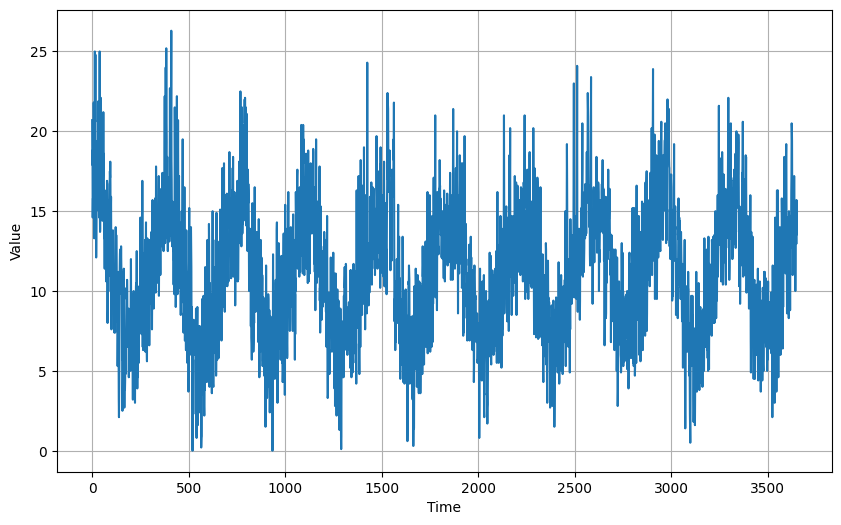

In [18]:


plt.figure(figsize=(10, 6))
plot_series(time, series)


In [23]:

def split_train_test(split_time):

    # Get the train set 
    time_train = time[:split_time]
    x_train = series[:split_time]
    
    # Get the test set and keep it away to validate, only once, the final model's performance  
    time_test = time[split_time:]
    x_test = series[split_time:]

    return time_train, x_train, time_test, x_test
    


In [24]:

time_train, x_train, time_test, x_test = split_train_test(3400)



In [132]:
x_train

array([20.7, 17.9, 18.8, ..., 11.2, 12.7, 13.7])

In [79]:
time_train

array([   0,    1,    2, ..., 3397, 3398, 3399])

In [64]:

len(x_train)


3400

In [81]:
# Complicated way

# def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
#     # YOUR CODE HERE
#     """Generates dataset windows

#     Args:
#       series (array of float) - contains the values of the time series
#       window_size (int) - the number of time steps to include in the feature
#       batch_size (int) - the batch size
#       shuffle_buffer(int) - buffer size to use for the shuffle method

#     Returns:
#       dataset (TF Dataset) - TF Dataset containing time windows
#     """
#     training_data = []
#     label = []
  
#     # Generate a TF Dataset from the series values
#     dataset = tf.data.Dataset.from_tensor_slices(series)

    
#     # Window the data but only take those with the specified size
#     dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
#     # Flatten the windows by putting its elements in a single batch
#     dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) ##the None dimension invoked by window.batch is 
#     ##of course necessary 

#     # Create tuples with features and labels 
#     dataset = dataset.map(lambda window: (window[:-1], window[-1]))


#     # # Shuffle the windows
#     dataset = dataset.shuffle(shuffle_buffer)
    
#     # # Create batches of windows
#     dataset = dataset.batch(batch_size).prefetch(1)

#     for value, target in dataset:

#         training_data.append((value))
#         label.append((target))
        
        
    
#     return training_data, label


In [207]:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer=False):
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) ##the None dimension invoked by window.batch is 
    ##of course necessary 

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    if shuffle_buffer:
        # # Shuffle the windows
        dataset = dataset.shuffle(shuffle_buffer)
    
    # # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
        
    return dataset



In [215]:

def model_build():
    tf.random.set_seed(51)
    np.random.seed(51)
    model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    optimizer = tf.keras.optimizers.legacy.SGD(momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
    return model



In [261]:
len(series)

3650

In [262]:
3650*0.20

730.0

In [275]:

def cv_loop(n_splits, series, lr_schedule, window_size, batch_size, train_shuffle):

    entire_history = {}

    tscv = TimeSeriesSplit(n_splits, test_size=600)

    for train_index, val_index in tscv.split(series):
        tf.keras.backend.clear_session()
        train_series, val_series = series[train_index], series[val_index]
    
        # Apply your windowed_dataset function to create TF datasets
        train_dataset = windowed_dataset(train_series, window_size, batch_size, train_shuffle)
        val_dataset = windowed_dataset(val_series, window_size, batch_size, shuffle_buffer=False)  # Note: Might not need to shuffle the test/validation set
        
        # Example model training and evaluation
        model = model_build()  # Function to create your model
    
        history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[lr_schedule], verbose=1)
        entire_history.update(history.history)
    
    return entire_history
        


In [276]:
window_size = 30
batch_size = 32
# shuffle_buffer_size = 600
n_splits = 3
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))



In [277]:

history = cv_loop(n_splits, x_train, lr_schedule, window_size, batch_size, train_shuffle=600)


Epoch 1/10
     50/Unknown - 8s 77ms/step - loss: 3.1271 - mae: 3.5972

2024-03-11 18:47:27.666460: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6800770782363861766
2024-03-11 18:47:27.666473: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2046703365598763984
2024-03-11 18:47:27.666477: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15901792544348005593
2024-03-11 18:47:27.666496: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17479980642100060928
2024-03-11 18:47:27.666502: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 574612551388546600


50/50 [==============================] - 10s 109ms/step - loss: 3.1271 - mae: 3.5972 - val_loss: 2.0500 - val_mae: 2.5109 - lr: 1.0000e-06
Epoch 2/10
 4/50 [=>............................] - ETA: 1s - loss: 2.2744 - mae: 2.7301

2024-03-11 18:47:29.220055: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16834384202421144992
2024-03-11 18:47:29.220075: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18320276400750526241
2024-03-11 18:47:29.220080: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13410326744965630163
2024-03-11 18:47:29.220085: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16997745998076452205
2024-03-11 18:47:29.220088: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18090838176501485349


50/50 [==============================] - 2s 30ms/step - loss: 2.1787 - mae: 2.6343 - val_loss: 1.7790 - val_mae: 2.2344 - lr: 1.1220e-06
Epoch 3/10
50/50 [==============================] - 1s 27ms/step - loss: 2.0599 - mae: 2.5163 - val_loss: 1.7241 - val_mae: 2.1817 - lr: 1.2589e-06
Epoch 4/10
50/50 [==============================] - 1s 29ms/step - loss: 1.9585 - mae: 2.4170 - val_loss: 1.6640 - val_mae: 2.1201 - lr: 1.4125e-06
Epoch 5/10
50/50 [==============================] - 1s 27ms/step - loss: 1.8974 - mae: 2.3524 - val_loss: 1.7235 - val_mae: 2.1722 - lr: 1.5849e-06
Epoch 6/10
50/50 [==============================] - 1s 27ms/step - loss: 1.8667 - mae: 2.3203 - val_loss: 1.6053 - val_mae: 2.0548 - lr: 1.7783e-06
Epoch 7/10
50/50 [==============================] - 2s 31ms/step - loss: 1.8088 - mae: 2.2623 - val_loss: 1.6227 - val_mae: 2.0713 - lr: 1.9953e-06
Epoch 8/10
50/50 [==============================] - 1s 27ms/step - loss: 1.8467 - mae: 2.3029 - val_loss: 1.5723 - val_mae:

2024-03-11 18:47:48.862056: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2046703365598763984
2024-03-11 18:47:48.862071: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6800770782363861766
2024-03-11 18:47:48.862091: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17479980642100060928
2024-03-11 18:47:48.862101: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 574612551388546600
2024-03-11 18:47:48.862106: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15901792544348005593


68/68 [==============================] - 7s 75ms/step - loss: 5.2196 - mae: 5.6931 - val_loss: 2.2081 - val_mae: 2.6650 - lr: 1.0000e-06
Epoch 2/10
 7/68 [==>...........................] - ETA: 1s - loss: 2.3247 - mae: 2.7802

2024-03-11 18:47:50.137835: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16834384202421144992
2024-03-11 18:47:50.137852: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13410326744965630163
2024-03-11 18:47:50.137862: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16997745998076452205
2024-03-11 18:47:50.137865: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18320276400750526241


68/68 [==============================] - 2s 29ms/step - loss: 2.2670 - mae: 2.7269 - val_loss: 2.1071 - val_mae: 2.5632 - lr: 1.1220e-06
Epoch 3/10
68/68 [==============================] - 2s 26ms/step - loss: 2.1801 - mae: 2.6382 - val_loss: 2.0417 - val_mae: 2.4956 - lr: 1.2589e-06
Epoch 4/10
68/68 [==============================] - 2s 27ms/step - loss: 2.1337 - mae: 2.5891 - val_loss: 1.9769 - val_mae: 2.4298 - lr: 1.4125e-06
Epoch 5/10
68/68 [==============================] - 2s 26ms/step - loss: 2.0904 - mae: 2.5443 - val_loss: 1.9338 - val_mae: 2.3876 - lr: 1.5849e-06
Epoch 6/10
68/68 [==============================] - 2s 28ms/step - loss: 2.0715 - mae: 2.5278 - val_loss: 2.0058 - val_mae: 2.4577 - lr: 1.7783e-06
Epoch 7/10
68/68 [==============================] - 2s 31ms/step - loss: 2.0155 - mae: 2.4698 - val_loss: 1.8429 - val_mae: 2.2958 - lr: 1.9953e-06
Epoch 8/10
68/68 [==============================] - 2s 29ms/step - loss: 1.9771 - mae: 2.4307 - val_loss: 1.8259 - val_mae:

2024-03-11 18:48:14.631906: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6800770782363861766
2024-03-11 18:48:14.631933: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15901792544348005593


87/87 [==============================] - 8s 67ms/step - loss: 5.7245 - mae: 6.2005 - val_loss: 2.5559 - val_mae: 3.0217 - lr: 1.0000e-06
Epoch 2/10
 7/87 [=>............................] - ETA: 1s - loss: 2.5211 - mae: 2.9915

2024-03-11 18:48:16.172427: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16834384202421144992
2024-03-11 18:48:16.172451: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13410326744965630163
2024-03-11 18:48:16.172473: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18090838176501485349
2024-03-11 18:48:16.172477: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16997745998076452205
2024-03-11 18:48:16.172480: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18320276400750526241


87/87 [==============================] - 2s 26ms/step - loss: 2.1104 - mae: 2.5689 - val_loss: 1.9054 - val_mae: 2.3618 - lr: 1.1220e-06
Epoch 3/10
87/87 [==============================] - 2s 27ms/step - loss: 1.7727 - mae: 2.2229 - val_loss: 1.6923 - val_mae: 2.1420 - lr: 1.2589e-06
Epoch 4/10
87/87 [==============================] - 2s 24ms/step - loss: 1.7064 - mae: 2.1567 - val_loss: 1.6592 - val_mae: 2.1091 - lr: 1.4125e-06
Epoch 5/10
87/87 [==============================] - 2s 26ms/step - loss: 1.6891 - mae: 2.1363 - val_loss: 1.6875 - val_mae: 2.1401 - lr: 1.5849e-06
Epoch 6/10
87/87 [==============================] - 2s 26ms/step - loss: 1.6859 - mae: 2.1343 - val_loss: 1.6145 - val_mae: 2.0615 - lr: 1.7783e-06
Epoch 7/10
87/87 [==============================] - 2s 25ms/step - loss: 1.6573 - mae: 2.1019 - val_loss: 1.6041 - val_mae: 2.0505 - lr: 1.9953e-06
Epoch 8/10
87/87 [==============================] - 2s 25ms/step - loss: 1.6717 - mae: 2.1204 - val_loss: 1.6186 - val_mae:

In [278]:

history


{'loss': [5.724515438079834,
  2.110377550125122,
  1.7726643085479736,
  1.7063591480255127,
  1.6890671253204346,
  1.6858609914779663,
  1.6573339700698853,
  1.6716972589492798,
  1.6598308086395264,
  1.635938048362732],
 'mae': [6.200532913208008,
  2.5689427852630615,
  2.2229063510894775,
  2.1567492485046387,
  2.136322498321533,
  2.1343324184417725,
  2.101867437362671,
  2.1203620433807373,
  2.106342077255249,
  2.081625461578369],
 'val_loss': [2.55590558052063,
  1.9054173231124878,
  1.692261815071106,
  1.6592128276824951,
  1.687463641166687,
  1.6145273447036743,
  1.60413658618927,
  1.6185593605041504,
  1.5742254257202148,
  1.575939416885376],
 'val_mae': [3.0217337608337402,
  2.3617665767669678,
  2.1419754028320312,
  2.1091115474700928,
  2.1400694847106934,
  2.0615451335906982,
  2.050527572631836,
  2.063293218612671,
  2.019467830657959,
  2.021965265274048],
 'lr': [1e-06,
  1.1220185e-06,
  1.2589254e-06,
  1.4125376e-06,
  1.5848932e-06,
  1.7782794e-0

In [279]:

def plot_learning_curve_loss(history):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1, 6])
    plt.legend(loc='upper right')
    plt.show()



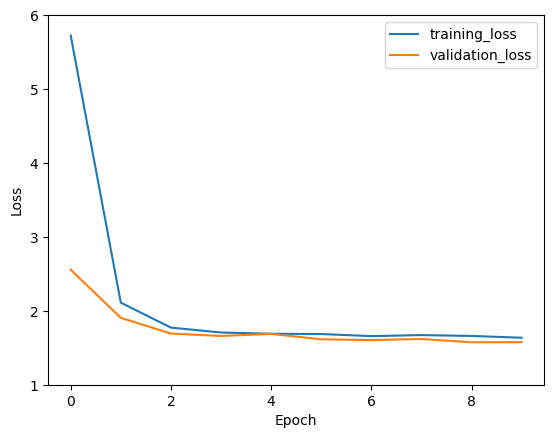

In [280]:


plot_learning_curve_loss(history)


In [281]:

def plot_learning_curve_metric(history):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.ylim([1, 7])
    plt.legend(loc='upper right')


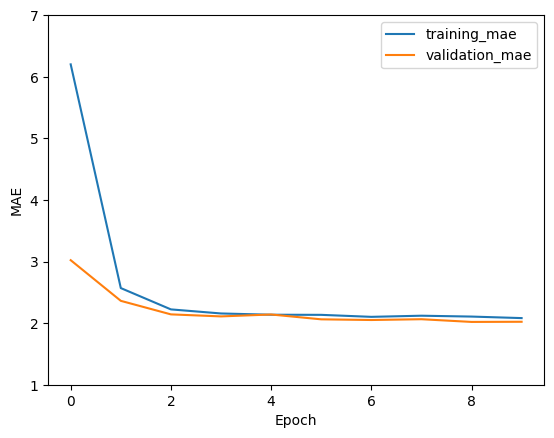

In [282]:

plot_learning_curve_metric(history)


In [283]:
from tensorflow.keras.backend import clear_session
clear_session()

In [285]:
del history, df
gc.collect()

67000